# Amazon Augmented AI (Amazon A2I) integration with Amazon SageMaker Hosted Endpoint for Object Detection and Model Retraining [Example]

1. [Introduction](#Introduction)
2. [Setup](#Setup)
4. [Create Control Plane Resources](#Create-Control-Plane-Resources)
    1. [Create Human Task UI](#Create-Human-Task-UI)
    2. [Create the Flow Definition](#Create-the-Flow-Definition)
5. [Starting Human Loops](#Starting-Human-Loops)
    1. [Wait For Workers to Complete Task](#Wait-For-Workers-to-Complete-Task)
    2. [Check Status of Human Loop](#Check-Status-of-Human-Loop)
    3. [View Task Results](#View-Task-Results)
6. [Incremental training with SageMaker (Optional)](#Incremental-training-with-SageMaker-(Optional))

## Introduction

Amazon Augmented AI (Amazon A2I) makes it easy to build the workflows required for human review of ML predictions. Amazon A2I brings human review to all developers, removing the undifferentiated heavy lifting associated with building human review systems or managing large numbers of human reviewers. 

You can create your own workflows for ML models built on Amazon SageMaker or any other tools. Using Amazon A2I, you can allow human reviewers to step in when a model is unable to make a high confidence prediction or to audit its predictions on an on-going basis. 

Learn more here: https://aws.amazon.com/augmented-ai/

In this tutorial, we will show how you can use **Amazon A2I with an Amazon SageMaker Hosted Endpoint.** We will be using an exisiting object detection endpoint in this notebook. We will also demonstrate how to manipulate the A2I output to perform incremental training to improve the model accuracy with the newly labeled data using A2I.

For more in depth instructions, visit https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-getting-started.html

To incorporate Amazon A2I into your human review workflows, you need three resources:

* A **worker task template** to create a worker UI. The worker UI displays your input data, such as documents or images, and instructions to workers. It also provides interactive tools that the worker uses to complete your tasks. For more information, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-instructions-overview.html

* A **human review workflow**, also referred to as a flow definition. You use the flow definition to configure your human workforce and provide information about how to accomplish the human review task. You can create a flow definition in the Amazon Augmented AI console or with Amazon A2I APIs. To learn more about both of these options, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html

* A **human loop** to start your human review workflow. When you use one of the built-in task types, the corresponding AWS service creates and starts a human loop on your behalf when the conditions specified in your flow definition are met or for each object if no conditions were specified. When a human loop is triggered, human review tasks are sent to the workers as specified in the flow definition.

When using a custom task type, as this tutorial will show, you start a human loop using the Amazon Augmented AI Runtime API. When you call `start_human_loop()` in your custom application, a task is sent to human reviewers.

## Setup
This notebook is developed and tested in a SageMaker Notebook Instance with a `ml.t2.medium` instance. It is recommended to execute the notebook in the same environment for best experience.
### Install Latest SDK

In [1]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip
!pip install boto3 --upgrade
!pip install -U botocore

  Using cached pip-20.2.4-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 97 kB 4.6 MB/s eta 0:00:011
     |████████████████████████████████| 6.8 MB 8.9 MB/s eta 0:00:01
  Created wheel for boto3: filename=boto3-1.16.17-py2.py3-none-any.whl size=128454 sha256=4d3b15cc81d10f38e708504547db446b168808588217410c9a3ff754a34729f6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d4/a0/be/d8ebe49b4c64c854bf838365a54e6491546e2b8b4c22b2bdef
Successfully built boto3
  Attempting uninstall: botocore
    Found existing installation: botocore 1.19.9
    Uninstalling botocore-1.19.9:
      Successfully uninstalled botocore-1.19.9
  Attempting uninstall: boto3
    Found existing installation: boto3 1.16.9
    Uninstalling boto3-1.16.9:
      Successfully uninstalled boto3-1.16.9
ERROR: After October 2020 you may experience errors whe

We need to set up the following data:
* `region` - Region to call A2I.
* `BUCKET` - A S3 bucket accessible by the given role
    * Used to store the sample images & output results
    * Must be within the same region A2I is called from
* `role` - The IAM role used as part of StartHumanLoop. By default, this notebook will use the execution role
* `workteam` - Group of people to send the work to

In [2]:
# Region 
region = 'us-west-2'

### Role and Permissions

The AWS IAM Role used to execute the notebook needs to have the following permissions:

* SagemakerFullAccess
* AmazonSageMakerMechanicalTurkAccess (if using MechanicalTurk as your Workforce)

In [3]:
from sagemaker import get_execution_role
import sagemaker

# Setting Role to the default SageMaker Execution Role
role = get_execution_role()
display(role)

'arn:aws:iam::332394936065:role/TeamRole'

#### Setup Bucket and Paths

In [4]:
import os
import boto3
import botocore

sess = sagemaker.Session()
BUCKET = sess.default_bucket()
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'
MODEL_PATH = f's3://{BUCKET}/model'

### Object detection with Amazon SageMaker

To demonstrate A2I with Amazon SageMaker hosted endpoint, we will take a trained object detection model from a S3 bucket and host it on the SageMaker endpoint for real-time prediction. Wonder how the model is trained? Training a computer vision model with SageMaker is easy, please follow [this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) to train a object detection model using Single Shot multibox Detector (SSD) algorithm and PASCAL VOC dataset and host it for real-time prediction. The provided model is trained following [the notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) step by step.

#### Load the model and create an endpoint
The next cell will setup an endpoint from a trained model. It will take about 3 minutes.

In [ ]:
import time
from sagemaker.amazon.amazon_estimator import get_image_uri

source_model_data_s3_uri = 's3://aws-sagemaker-augmented-ai-example/model/model.tar.gz'

!aws s3 cp {source_model_data_s3_uri} {MODEL_PATH}/model.tar.gz

model_data_s3_uri = f'{MODEL_PATH}/model.tar.gz'
print(model_data_s3_uri)

timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_name = 'DEMO-object-detection-augmented-ai-' + timestamp

# image = '433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:1'
image = get_image_uri(region, 'object-detection', repo_version='latest')
model = sagemaker.model.Model(model_data=model_data_s3_uri, 
                              image_uri=image, 
                              name='a2i-obj-detection',
                              role = role,
                              predictor_cls = sagemaker.predictor.RealTimePredictor,
                              sagemaker_session = sess)

object_detector = model.deploy(initial_instance_count = 1,
                               instance_type = 'ml.m4.xlarge',
                               endpoint_name = endpoint_name)

# object_detector.content_type = 'image/jpeg'

copy: s3://aws-sagemaker-augmented-ai-example/model/model.tar.gz to s3://sagemaker-us-west-2-332394936065/model/model.tar.gz
s3://sagemaker-us-west-2-332394936065/model/model.tar.gz


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


-------

#### object detection helper functions

In [6]:
from sagemaker.predictor import Predictor
import matplotlib.pyplot as plt
import matplotlib.patches as patches    
import matplotlib.image as mpimg
import random
import numpy as np
import json

def visualize_detection(img_file, dets, classes=[], thresh=0.6):
    """
    visualize detections in one image
    Parameters:
    ----------
    img : numpy.array
        image, in bgr format
    dets : numpy.array
        ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
        each row is one object
    classes : tuple or list of str
        class names
    thresh : float
        score threshold
    """
    img=mpimg.imread(img_file)
    f, ax = plt.subplots(1, 1)
    ax.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    output = []
    for det in dets:
        (klass, score, x0, y0, x1, y1) = det
        cls_id = int(klass)
        class_name = str(cls_id)
        if classes and len(classes) > cls_id:
            class_name = classes[cls_id]
        output.append([class_name, score])
        if score < thresh:
            continue
        if cls_id not in colors:
            colors[cls_id] = (random.random(), random.random(), random.random())
        xmin = int(x0 * width)
        ymin = int(y0 * height)
        xmax = int(x1 * width)
        ymax = int(y1 * height)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
        ax.add_patch(rect)


        ax.text(xmin, ymin - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                          fontsize=12, color='white')

    return f, output

runtime = boto3.Session().client(service_name='sagemaker-runtime')    
    
def load_and_predict(file_name, predictor, threshold=0.5):
    """
    load an image, make object detection to an predictor, and visualize detections
    Parameters:
    ----------
    file_name : str
        image file location, in str format
    predictor : sagemaker.predictor.RealTimePredictor
        a predictor loaded from hosted endpoint
    threshold : float
        score threshold for bounding box display
    """
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)

    response = runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='image/jpeg',
            Body=b)

    detections = json.loads(response['Body'].read().decode('utf-8'))
    
    fig, detection_filtered = visualize_detection(file_name, detections['prediction'], 
                                                   object_categories, threshold)
    return  detection_filtered, fig

In [7]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
                     'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
                     'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

#### Sample Data
Let's take a look how the object detection looks like using some stock photos on the internet. The predicted class and the prediction probability is visualized along with the bounding box using the helper function.

In [8]:
test_photos_index = ['980382', '276517', '1571457']

if not os.path.isdir('sample-a2i-images'):
    os.mkdir('sample-a2i-images')
    
for ind in test_photos_index:
    !curl https://images.pexels.com/photos/{ind}/pexels-photo-{ind}.jpeg > sample-a2i-images/pexels-photo-{ind}.jpeg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1793k  100 1793k    0     0  3125k      0 --:--:-- --:--:-- --:--:-- 3125k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2265k  100 2265k    0     0  34.5M      0 --:--:-- --:--:-- --:--:-- 34.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2864k  100 2864k    0     0  5060k      0 --:--:-- --:--:-- --:--:-- 5060k


In [9]:
test_photos = ['sample-a2i-images/pexels-photo-980382.jpeg', # motorcycle
               'sample-a2i-images/pexels-photo-276517.jpeg', # bicycle
               'sample-a2i-images/pexels-photo-1571457.jpeg'] # sofa

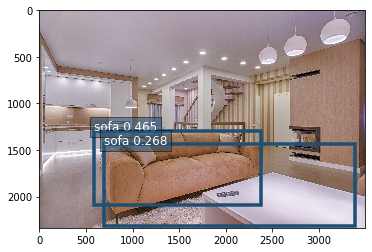

In [10]:
detection_filtered, f = load_and_predict(test_photos[2], object_detector, threshold=0.2)

Probability of 0.465 is considered quite low in modern computer vision and there is a mislabeling. This is due to the fact that the SSD model was under-trained for demonstration purposes in the [training notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb). However this under-trained model serves as a perfect example of brining human reviewers when a model is unable to make a high confidence prediction.

### Creating human review Workteam or Workforce

A workforce is the group of workers that you have selected to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Augmented AI takes care of sending tasks to workers. 

When you use a private workforce, you also create work teams, a group of workers from your workforce that are assigned to Amazon Augmented AI human review tasks. You can have multiple work teams and can assign one or more work teams to each job.

To create your Workteam, visit the instructions here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management.html

After you have created your workteam, replace YOUR_WORKTEAM_ARN below

In [16]:
WORKTEAM_ARN = 'arn:aws:sagemaker:us-east-1:230755935769:workteam/private-crowd/gt-trial-reduced'

Visit: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-permissions-security.html to add the necessary permissions to your role

## Client Setup

Here we are going to setup the rest of our clients. 

In [17]:
import io
import uuid

# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker', region)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon S3 client 
s3 = boto3.client('s3', region)

# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-sagemaker-object-detection-demo-' + timestamp

# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-sagemaker-object-detection-demo-' + timestamp

## Create Control Plane Resources

### Create Human Task UI

Create a human task UI resource, giving a UI template in liquid html. This template will be rendered to the human workers whenever human loop is required.

For over 70 pre built UIs, check: https://github.com/aws-samples/amazon-a2i-sample-task-uis.

We will be taking an [object detection UI](https://github.com/aws-samples/amazon-a2i-sample-task-uis/blob/master/images/bounding-box.liquid.html) and filling in the object categories in the `labels` variable in the template.

In [18]:
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
  <crowd-bounding-box
    name="annotatedResult"
    src="{{ task.input.taskObject | grant_read_access }}"
    header="Draw bounding boxes around all the objects in this image"
    labels="['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']"
  >
    <full-instructions header="Bounding Box Instructions" >
      <p>Use the bounding box tool to draw boxes around the requested target of interest:</p>
      <ol>
        <li>Draw a rectangle using your mouse over each instance of the target.</li>
        <li>Make sure the box does not cut into the target, leave a 2 - 3 pixel margin</li>
        <li>
          When targets are overlapping, draw a box around each object,
          include all contiguous parts of the target in the box.
          Do not include parts that are completely overlapped by another object.
        </li>
        <li>
          Do not include parts of the target that cannot be seen,
          even though you think you can interpolate the whole shape of the target.
        </li>
        <li>Avoid shadows, they're not considered as a part of the target.</li>
        <li>If the target goes off the screen, label up to the edge of the image.</li>
      </ol>
    </full-instructions>

    <short-instructions>
      Draw boxes around the requested target of interest.
    </short-instructions>
  </crowd-bounding-box>
</crowd-form>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [19]:
# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-east-1:230755935769:human-task-ui/ui-sagemaker-object-detection-demo-2020-11-11-13-33-06


### Create the Flow Definition

In this section, we're going to create a flow definition definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
* Where your output data will be stored.

This demo is going to use the API, but you can optionally create this workflow definition in the console as well. 

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.

In [20]:
create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= role,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify and locate the object in an image.",
            "TaskTitle": "Object detection a2i demo"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [21]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Active
Flow Definition is active


## Starting Human Loops

Now that we have setup our Flow Definition, we are ready to call our object detection endpoint on SageMaker and start our human loops. In this tutorial, we are interested in starting a HumanLoop only if the highest prediction probability score returned by our model for objects detected is less than 50%. 

So, with a bit of logic, we can check the response for each call to the SageMaker endpoint using `load_and_predict` helper function, and if the highest score is less than 50%, we will kick off a HumanLoop to engage our workforce for a human review. 

upload: sample-a2i-images/pexels-photo-276517.jpeg to s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-276517.jpeg
upload: sample-a2i-images/pexels-photo-1571457.jpeg to s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-1571457.jpeg
upload: sample-a2i-images/pexels-photo-980382.jpeg to s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-980382.jpeg
Object detection Confidence Score of motorbike is above than the threshold of 0.50
No human loop created. 

s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-276517.jpeg
Object detection Confidence Score of bicycle is less than the threshold of 0.50
Starting human loop with name: 88faecc1-428a-407c-9066-fcf37a22d3be  

s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-1571457.jpeg
Object detection Confidence Score of sofa is less than the threshold of 0.50
Starting human loop with name: 349

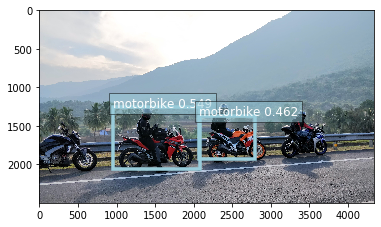

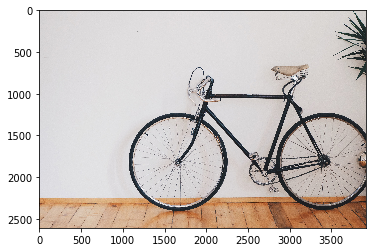

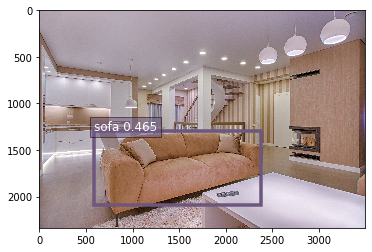

In [22]:
# Get the sample images to s3 bucket for a2i UI to display
!aws s3 sync ./sample-a2i-images/ s3://{BUCKET}/a2i-results/sample-a2i-images/
    
human_loops_started = []
SCORE_THRESHOLD = .50
for fname in test_photos:
    # Call SageMaker endpoint and not display any object detected with probability lower than 0.4.
    score_filtered, fig = load_and_predict(fname, object_detector, threshold=0.4)
    # Sort by prediction score so that the first item has the highest probability
    score_filtered.sort(key=lambda x: x[1], reverse=True)

    # Our condition for triggering a human review
    if (score_filtered[0][1] < SCORE_THRESHOLD):
        s3_fname='s3://%s/a2i-results/%s' % (BUCKET, fname)
        print(s3_fname)
        humanLoopName = str(uuid.uuid4())
        inputContent = {
            "initialValue": score_filtered[0][0],
            "taskObject": s3_fname # the s3 object will be passed to the worker task UI to render
        }
        # start an a2i human review loop with an input
        start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(inputContent)
            }
        )
        human_loops_started.append(humanLoopName)
        print(f'Object detection Confidence Score of %s is less than the threshold of %.2f' % (score_filtered[0][0], SCORE_THRESHOLD))
        print(f'Starting human loop with name: {humanLoopName}  \n')
    else:
        print(f'Object detection Confidence Score of %s is above than the threshold of %.2f' % (score_filtered[0][0], SCORE_THRESHOLD))
        print('No human loop created. \n')

### Check Status of Human Loop

In [23]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

HumanLoop Name: 88faecc1-428a-407c-9066-fcf37a22d3be
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://sagemaker-us-east-1-230755935769/a2i-results/fd-sagemaker-object-detection-demo-2020-11-11-13-33-06/2020/11/11/13/46/44/88faecc1-428a-407c-9066-fcf37a22d3be/output.json'}


HumanLoop Name: 349d8b0f-b3a3-4d3e-a845-26fdc3f405f3
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://sagemaker-us-east-1-230755935769/a2i-results/fd-sagemaker-object-detection-demo-2020-11-11-13-33-06/2020/11/11/13/46/45/349d8b0f-b3a3-4d3e-a845-26fdc3f405f3/output.json'}




### Wait For Workers to Complete Task
Since we are using private workteam, we should go to the labling UI to perform the inspection ourselves.

In [24]:
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://8wfnqz10vf.labeling.us-east-1.sagemaker.aws


### Check Status of Human Loop Again

In [25]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

HumanLoop Name: 88faecc1-428a-407c-9066-fcf37a22d3be
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://sagemaker-us-east-1-230755935769/a2i-results/fd-sagemaker-object-detection-demo-2020-11-11-13-33-06/2020/11/11/13/46/44/88faecc1-428a-407c-9066-fcf37a22d3be/output.json'}


HumanLoop Name: 349d8b0f-b3a3-4d3e-a845-26fdc3f405f3
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://sagemaker-us-east-1-230755935769/a2i-results/fd-sagemaker-object-detection-demo-2020-11-11-13-33-06/2020/11/11/13/46/45/349d8b0f-b3a3-4d3e-a845-26fdc3f405f3/output.json'}




### View Task Results  

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed. Note that the human answer, the label and the bounding box, is returned and saved in the json file.

In [26]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

{   'flowDefinitionArn': 'arn:aws:sagemaker:us-east-1:230755935769:flow-definition/fd-sagemaker-object-detection-demo-2020-11-11-13-33-06',
    'humanAnswers': [   {   'answerContent': {   'annotatedResult': {   'boundingBoxes': [   {   'height': 1767,
                                                                                                 'label': 'bicycle',
                                                                                                 'left': 1041,
                                                                                                 'top': 647,
                                                                                                 'width': 2864}],
                                                                        'inputImageProperties': {   'height': 2608,
                                                                                                    'width': 3911}}},
                            'submissionTime': '2020-11-11T13:4

## Incremental training with SageMaker (Optional)
Now that we have used the model to generate prediction on some random out-of-sample images and got unsatisfactory prediction (low probability). We also demonstrated how to use Amazon Augmented AI to review and label the image based on custom criteria. Next step in a typical machine learning life cycle is to include these cases with which the model has trouble in the next batch of training data for retraining purposes so that the model can now learn from a set of new training data to improve the model. In machine learning we call it [incremental training](https://docs.aws.amazon.com/sagemaker/latest/dg/incremental-training.html).

There are [three ways](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html#object-detection-inputoutput) to supply the image data and annotation to SageMaker built-in object detection algorithm. We trained our original model with the [RecordIO format](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) as we converted the PASCAL VOC images and annotations into RecordIO format. If you want to create a custom RecordIO data, you could follow the steps outlined [here](https://gluon-cv.mxnet.io/build/examples_datasets/detection_custom.html). Alternatively, SageMaker built-in object detection algorithm also takes JSON file as input. You could create one JSON file per image as in **Train with the Image Format** in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html#object-detection-inputoutput), or take an advantage of [pipe mode](https://aws.amazon.com/blogs/machine-learning/accelerate-model-training-using-faster-pipe-mode-on-amazon-sagemaker/) enabled by using [Augmented Manifest](https://docs.aws.amazon.com/sagemaker/latest/dg/augmented-manifest.html) as input format. Pipe mode accelerate overall model training time up to 35% by streaming the data into the training algorithm while it is running instead of copying data to the EBS volume attached to the training instance. We could construct augmented manifest file from the A2I output with the following function: 

In [28]:
object_categories_dict = {str(i): j for i, j in enumerate(object_categories)}

def convert_a2i_to_augmented_manifest(a2i_output):
    annotations = []
    confidence = []
    for i, bbox in enumerate(a2i_output['humanAnswers'][0]['answerContent']['annotatedResult']['boundingBoxes']):
        object_class_key = [key for (key, value) in object_categories_dict.items() if value == bbox['label']][0]
        obj = {'class_id': int(object_class_key), 
               'width': bbox['width'],
               'top': bbox['top'],
               'height': bbox['height'],
               'left': bbox['left']}
        annotations.append(obj)
        confidence.append({'confidence': 1})

    # We set "a2i-retraining" as the attribute name for this dataset. This will later be used in setting the training data
    augmented_manifest={'source-ref': a2i_output['inputContent']['taskObject'],
                        'a2i-retraining': {'annotations': annotations,
                                           'image_size': [{'width': a2i_output['humanAnswers'][0]['answerContent']['annotatedResult']['inputImageProperties']['width'],
                                                           'depth':3,
                                                           'height': a2i_output['humanAnswers'][0]['answerContent']['annotatedResult']['inputImageProperties']['height']}]},
                        'a2i-retraining-metadata': {'job-name': 'a2i/%s' % a2i_output['humanLoopName'],
                                                    'class-map': object_categories_dict,
                                                    'human-annotated':'yes',
                                                    'objects': confidence,
                                                    'creation-date': a2i_output['humanAnswers'][0]['submissionTime'],
                                                    'type':'groundtruth/object-detection'}}
    return augmented_manifest

This function will take an A2I output json and result in a json object that is compatible to how Amazon SageMaker Ground Truth outputs the result and how SageMaker built-in object detection algorithm expects from the input. In order to create a cohort of training images from all the images re-labeled by human reviewers in A2I console. You can loop through all the A2I output, convert the json file, and concatenate them into a JSON Lines file, with each line represents results of one image. 

In [29]:
output=[]
with open('augmented.manifest', 'w') as outfile:
    # convert the a2i json to augmented manifest for each human loop output
    for resp in completed_human_loops:
        splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
        output_bucket_key = splitted_string[1]

        response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
        content = response["Body"].read()
        json_output = json.loads(content)
        
        # convert using the function
        augmented_manifest = convert_a2i_to_augmented_manifest(json_output)
        print(json.dumps(augmented_manifest))
        json.dump(augmented_manifest, outfile)
        outfile.write('\n')
        output.append(augmented_manifest)
        print('\n')

{"source-ref": "s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-276517.jpeg", "a2i-retraining": {"annotations": [{"class_id": 1, "width": 2864, "top": 647, "height": 1767, "left": 1041}], "image_size": [{"width": 3911, "depth": 3, "height": 2608}]}, "a2i-retraining-metadata": {"job-name": "a2i/88faecc1-428a-407c-9066-fcf37a22d3be", "class-map": {"0": "aeroplane", "1": "bicycle", "2": "bird", "3": "boat", "4": "bottle", "5": "bus", "6": "car", "7": "cat", "8": "chair", "9": "cow", "10": "diningtable", "11": "dog", "12": "horse", "13": "motorbike", "14": "person", "15": "pottedplant", "16": "sheep", "17": "sofa", "18": "train", "19": "tvmonitor"}, "human-annotated": "yes", "objects": [{"confidence": 1}], "creation-date": "2020-11-11T13:48:28.089Z", "type": "groundtruth/object-detection"}}


{"source-ref": "s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-1571457.jpeg", "a2i-retraining": {"annotations": [{"class_id": 17, "wi

In [30]:
# take a look at how Json Lines looks like
!head -n2 augmented.manifest

{"source-ref": "s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-276517.jpeg", "a2i-retraining": {"annotations": [{"class_id": 1, "width": 2864, "top": 647, "height": 1767, "left": 1041}], "image_size": [{"width": 3911, "depth": 3, "height": 2608}]}, "a2i-retraining-metadata": {"job-name": "a2i/88faecc1-428a-407c-9066-fcf37a22d3be", "class-map": {"0": "aeroplane", "1": "bicycle", "2": "bird", "3": "boat", "4": "bottle", "5": "bus", "6": "car", "7": "cat", "8": "chair", "9": "cow", "10": "diningtable", "11": "dog", "12": "horse", "13": "motorbike", "14": "person", "15": "pottedplant", "16": "sheep", "17": "sofa", "18": "train", "19": "tvmonitor"}, "human-annotated": "yes", "objects": [{"confidence": 1}], "creation-date": "2020-11-11T13:48:28.089Z", "type": "groundtruth/object-detection"}}
{"source-ref": "s3://sagemaker-us-east-1-230755935769/a2i-results/sample-a2i-images/pexels-photo-1571457.jpeg", "a2i-retraining": {"annotations": [{"class_id": 17, "widt

In [31]:
# upload the manifest file to S3
!aws s3 cp augmented.manifest {OUTPUT_PATH}/augmented.manifest

upload: ./augmented.manifest to s3://sagemaker-us-east-1-230755935769/a2i-results/augmented.manifest


Similar to training with Ground Truth output augmented manifest file outlined in this [blog](https://aws.amazon.com/blogs/machine-learning/easily-train-models-using-datasets-labeled-by-amazon-sagemaker-ground-truth/), once we have collected enough data points, we can construct a new `Estimator` for incremental training. We will be using the hyperparameters exactly the same as how the first model was trained in the [training notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb), with an exception of using the weights from the trained model instead of pre-trained weights that comes with the algorithm (`use_pretrained_model=0`). Note that the following working code snippet is meant to demonstrate "how-to", incremental training with merely 1 or 2 new samples, as we did in this example, would not yield a model with meaningful improvement. *The training would take about 5 minutes.*

In [ ]:
# path definition
s3_train_data = f'{OUTPUT_PATH}/augmented.manifest'
s3_validation_data = s3_train_data # reusing the same data, but idealy you should use a mix of original validation data and newly labeled data
s3_output_location = f'{OUTPUT_PATH}/incremental-training'

num_training_samples = len(output)

# Create a model object set to using "Pipe" mode because we are inputing augmented manifest files.
new_od_model = sagemaker.estimator.Estimator(image, # same object detection image that we used for model hosting  
                                             role, 
                                             train_instance_count=1, 
                                             train_instance_type='ml.p3.2xlarge', 
                                             train_volume_size = 50, 
                                             train_max_run = 360000, 
                                             input_mode = 'Pipe', 
                                             output_path=s3_output_location, 
                                             sagemaker_session=sess) 

# same set of hyperparameters from the original training job
new_od_model.set_hyperparameters(base_network='resnet-50',
                                 use_pretrained_model=0, # we are going to use our own model
                                 num_classes=20,
                                 mini_batch_size=1,
                                 epochs=1,
                                 lr_scheduler_step='3,6',
                                 lr_scheduler_factor=0.1,
                                 optimizer='sgd',
                                 momentum=0.9,
                                 weight_decay=0.0005,
                                 overlap_threshold=0.5,
                                 nms_threshold=0.45,
                                 image_shape=300,
                                 label_width=350,
                                 num_training_samples=num_training_samples)

# setting the input data
train_data = sagemaker.session.s3_input(s3_train_data, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-recordio',
                                        record_wrapping='RecordIO',
                                        s3_data_type='AugmentedManifestFile', 
                                        attribute_names=['source-ref', 'a2i-retraining'])
validation_data = sagemaker.session.s3_input(s3_validation_data, 
                                             distribution='FullyReplicated', 
                                             content_type='application/x-recordio',
                                             record_wrapping='RecordIO',
                                             s3_data_type='AugmentedManifestFile', 
                                             attribute_names=['source-ref', 'a2i-retraining'])

# Use the output model from the original training job.  
model_data = sagemaker.session.s3_input(model_data_s3_uri, 
                                        distribution='FullyReplicated',
                                        content_type='application/x-sagemaker-model', 
                                        s3_data_type='S3Prefix',
                                        input_mode = 'File')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'model': model_data}
                 
new_od_model.fit(inputs=data_channels, logs=True)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-11-11 13:51:13 Starting - Starting the training job...
2020-11-11 13:51:16 Starting - Launching requested ML instances..

After training, you would get a new model in the `s3_output_location`, you can deploy it to a new endpoint or modify an endpoint without taking models that are already deployed into production out of service. For example, you can add new model variants, update the ML Compute instance configurations of existing model variants, or change the distribution of traffic among model variants. To modify an endpoint, you provide a new endpoint configuration. Amazon SageMaker implements the changes without any downtime. For more information, see [UpdateEndpoint](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_UpdateEndpoint.html) and [UpdateEndpointWeightsAndCapacities](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_UpdateEndpointWeightsAndCapacities.html). 

### The End, but....!
This is the end of the example. Remember to execute the next cell to delete the endpoint otherwise it will continue to incur charges.

In [ ]:
object_detector.delete_endpoint()